In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
#import warnings
#warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Train_set.drop(Test_set.columns.symmetric_difference(list(Train_set)), axis=1, inplace=True)

# Fill Missing values

In [3]:
class Fill_Miss_Value(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_con=False):
        self.drop_con = drop_con
    
    def fit(self, X, y=None):
        
        global  numerical_att, categorical_att, frequency_cat, droped_colum, median
        
        droped_colum = []
        
        #drops columns that less than half length values
        if (self.drop_con):            
            a = np.ceil(len(X)*(0.5)),            
            for att in list(X):                
                if X[att].notnull().sum() < a:                                    
                    droped_colum.append(att)                    
                    X.drop(att, axis=1, inplace=True)
        
        numerical_att = [att for att in dict(Train_set.dtypes)
                                if dict(Train_set.dtypes)[att] != 'object']        
        frequency_cat = {}
                       
        categorical_att = X.columns.symmetric_difference(numerical_att)
                
        median = X[numerical_att].median(axis=0)
        
        for att in categorical_att:
            frequency_cat[att] = X[att].value_counts()
                    
        return self


    def transform(self, X):
        median = X[numerical_att].median(axis=0)
        
        for att, val in zip(numerical_att, median):
            X[att].fillna(val, inplace=True)
        
        for key , val in frequency_cat.items():
                
            X[key].fillna(val.idxmax(), inplace=True)
                
            categorical_att = list(X)
        
        return X

# Feature Engineering

In [4]:
class Feature_Combine_Attribute_Adder(BaseEstimator, TransformerMixin):
    
    def __init__(self, operation_atts=None, drop_columns=None, drop_con=False):
        self.drop_columns = drop_columns
        self.operation_atts = operation_atts
        self.drop_con = drop_con
    
    def fit(self, X, y=None): 
        return self
        

    
    def transform(self, X):    
     
       #select operator for feature operation 
        operation = {'+': (lambda a, b: a + b),
                     '-': (lambda a, b: a - b),
                     '/': (lambda a, b: a / b),
                     '*': (lambda a, b: a * b)}
        
        
        for key , val in self.operation_atts.items():  
            
            if isinstance(val, str):
            
                if (len(val.split()) == 1) : 
                    
                    #numerical attribute transform to catecorical attribute 
                    if ((X.dtypes)[val] in ['int32', 'int64', 'float32', 'float64']):
                        
                        mapping = dict(zip(X[val].unique(),
                                          [str(m) for m in X[val].unique()]))
                        
                        X[key] = X[val].map(mapping)
                        
            
                if (len(val.split()) >= 2):

                    #both of them numerical attribute for combine
                    att1, opp, att2 = val.split()

                    X[key] = operation[opp](X.loc[:,att1].values, X.loc[:,att2].values)
                    
                    
            #numerical attribute transform to categorical 
            else:
                new_att_name = key + '_' + 'CAT'
                
                X[new_att_name] = pd.cut(X[key], len(val), labels=val)
                X[new_att_name] = X[new_att_name].astype('object')
            
        if (self.drop_con):
           
            return X.drop(self.drop_columns, axis=1, inplace=True)
        
        return X

# Transform Categoric Columns To OneHotEncode

In [5]:
class TextColum_To_CategoricColum(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
            
        categorical_att = [att for att in dict(X.dtypes)
                                if dict(X.dtypes)[att] in ['object']]
                    
        
        oneHot = OneHotEncoder(sparse=False).fit(X[categorical_att])
        oneHot_data = oneHot.transform(X[categorical_att])
        oneHot_columns = [name for name in oneHot.get_feature_names(categorical_att)]
            
        df = pd.DataFrame(oneHot_data, index=X.index,
                           columns=oneHot_columns, dtype=np.int32)    
        
        return pd.concat([X.drop(categorical_att, axis=1), df], axis=1)

# Proportion Data for Test_Set

In [6]:
class Select_Proportion_Col(BaseEstimator, TransformerMixin):
    
    def __init__(self, Label=None):
        self.Label = Label
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        global prop_att
        
        X[self.Label.name] = self.Label
        X[self.Label.name] = X[self.Label.name].astype('float64')
        
        
        corr_matrix= X.corr()
        
        sorted_cor_matrix = corr_matrix[self.Label.name].sort_values(ascending=False).items()
            
        for att, val in sorted_cor_matrix:
            
            if not(att == self.Label.name):
                
                if (not(X[att].dtypes == type('object'))  & (val < 1.0)):
                    
                    if (len(X[att].unique()) > len(X)/2):
                        prop_att = X[att].copy()                     
                        break
         
        X.drop([self.Label.name], axis=1, inplace=True)
        
        return X

# Scaling Numeric Data

In [7]:
class Scaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_max=False):
        self.min_max = min_max
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        numerical_att = [att for att in dict(Train_set.dtypes)
                                if not(dict(Train_set.dtypes)[att] in ['object'])]                
        
        if (self.min_max):
            scaler = MinMaxScaler()
            data = scaler.fit_transform(X[numerical_att])
            X[numerical_att]= pd.DataFrame(data, index=X.index, columns=numerical_att)[numerical_att]
        else:
            scaler = StandardScaler()
            data = scaler.fit_transform(X[numerical_att])
            X[numerical_att]= pd.DataFrame(data, index=X.index, columns=numerical_att)[numerical_att]
            
        return X

# Column Reduction

In [8]:
class Column_Reduction(BaseEstimator, TransformerMixin):
    
    def __init__(self, Label=None, thresh=0.0,  drop_con=False, drp_list=None, train_con=False):
        self.thresh = thresh
        self.Label = Label
        self.drop_con = drop_con
        self.drp_list = drp_list
        self.train_con = train_con
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
              
        if (self.drop_con):
            X.drop(self.drp_list, axis=1, inplace=True)
        
        if (self.train_con):
            X[self.Label.name] = self.Label

            corr_matrix = X.corr()

            temp_list = corr_matrix[self.Label.name][(np.abs(corr_matrix[self.Label.name]) >= self.thresh)&
                                                 (np.abs(corr_matrix[self.Label.name]) < 1.0)].index      
                        
            return X[temp_list]


# Split Dataset Train_set Test_set

In [64]:
class Split_Data_To_Train_Test_Set(BaseEstimator, TransformerMixin):
    
    def __init__(self, Label=None,test_size=0.2):
        
        self.Label = Label
        self.test_size = test_size
        
    def fit(self, X, y=None):  
        
        return self
            
    def transform(self, X):
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=self.test_size, random_state=42)

        for train_index, test_index in split.split(X, X[self.Label]):
            train_set = X.iloc[(train_index - 1)]
            test_set = X.iloc[(test_index - 1)]
        

        
        return (train_set, test_set)


# Load Data

In [65]:
Test_set = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

Test_set_Labels = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")

Train_set = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

#Train_set.drop(Train_set[(Train_set['SalePrice'] > 400000)].index, inplace=True)


Train_set_Labels = Train_set['SalePrice']


Train_set_Labels.index = Train_set['Id'].values

Train_set.drop(['SalePrice'], axis=1, inplace=True)

for set_ in (Test_set, Test_set_Labels, Train_set):
    set_.index = set_["Id"].values
    set_.drop(['Id'], axis=1, inplace=True)

In [66]:
Train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1432 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1432 non-null   int64  
 1   MSZoning       1432 non-null   object 
 2   LotFrontage    1175 non-null   float64
 3   LotArea        1432 non-null   int64  
 4   Street         1432 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1432 non-null   object 
 7   LandContour    1432 non-null   object 
 8   Utilities      1432 non-null   object 
 9   LotConfig      1432 non-null   object 
 10  LandSlope      1432 non-null   object 
 11  Neighborhood   1432 non-null   object 
 12  Condition1     1432 non-null   object 
 13  Condition2     1432 non-null   object 
 14  BldgType       1432 non-null   object 
 15  HouseStyle     1432 non-null   object 
 16  OverallQual    1432 non-null   int64  
 17  OverallCond    1432 non-null   int64  
 18  YearBuil

In [67]:
Train_set[['YrSold', 'YearBuilt', 'Fireplaces','TotRmsAbvGrd','MSSubClass']]

,YrSold,YearBuilt,Fireplaces,TotRmsAbvGrd,MSSubClass
1,2008,2003,0,8,60
2,2007,1976,1,6,20
3,2008,2001,1,6,60
4,2006,1915,1,7,70
5,2008,2000,1,9,60
...,...,...,...,...,...
1456,2007,1999,1,7,60
1457,2010,1978,2,7,20
1458,2010,1941,2,9,70
1459,2010,1950,0,5,20


In [68]:
len(Train_set['MSSubClass'].unique())

15

# Preparing Data

In [69]:
arithmetic_operation1 = {
                 'House_Age':'YrSold - YearBuilt',
                 'AfterRemodAge':'YrSold - YearRemodAdd',
                 'TotalFloorSquareF':'1stFlrSF + 2ndFlrSF',
                 'TotalBsmtFinSF':'BsmtFinSF1 + BsmtFinSF2',
                 'TotalBsmtBath':'BsmtFullBath + BsmtHalfBath',
                 'TotalBathroom':'FullBath + HalfBath',
                 'Garage_Age':'YrSold - GarageYrBlt',
                 'Per_Fireplaces_Room': 'Fireplaces / TotRmsAbvGrd',
                 'Ratio_WoodFlSF': 'WoodDeckSF + TotalFloorSquareF'}


numAtt_to_catAtt1 = {'Cat_MSSubClass':'MSSubClass'}

numAtt_to_catAtt2 = {'House_Age': ['NEW', 'MIDLE', 'OLD'],                       
                      'Garage_Age': ['NEW', 'MIDLE', 'OLD']}

In [70]:
def Construct_Pipeline(thresh=0.0, scaler_con=False):
    
    pipeline_1 = Pipeline([
            ('fill_miss_values', Fill_Miss_Value(drop_con=True)),   
            ('tr_Cat',TextColum_To_CategoricColum()),
            ('prop_att',Select_Proportion_Col(Label=Train_set_Labels)),
            ('scaler', Scaler(min_max=scaler_con)),
            ('column_reduction', Column_Reduction(Label=Train_set_Labels, thresh=thresh, train_con=True))])


    drop_Num_List1 = ['MSSubClass']
    pipeline_2 = Pipeline([
            ('fill_miss_values', Fill_Miss_Value(drop_con=True)),
            ('feature_combine', Feature_Combine_Attribute_Adder(operation_atts = numAtt_to_catAtt1)), 
            ('tr_Cat',TextColum_To_CategoricColum()),
            ('prop_att',Select_Proportion_Col(Label=Train_set_Labels)),
            ('scaler', Scaler(min_max=scaler_con)),
            ('column_reduction', Column_Reduction(Label=Train_set_Labels, thresh=thresh, train_con=True,
                                                 drop_con=True, drp_list=drop_Num_List1))])


    drop_Num_List2 = ['YearBuilt','YearRemodAdd', 'GarageYrBlt','YrSold']
    pipeline_3 = Pipeline([
            ('fill_miss_values', Fill_Miss_Value(drop_con=True)),
            ('feature_combine', Feature_Combine_Attribute_Adder(operation_atts = arithmetic_operation1)),    
            ('tr_Cat',TextColum_To_CategoricColum()),
            ('prop_att',Select_Proportion_Col(Label=Train_set_Labels)),
            ('scaler', Scaler(min_max=scaler_con)),
            ('column_reduction', Column_Reduction(Label=Train_set_Labels, thresh=thresh, train_con=True,
                                                  drop_con=True, drp_list=drop_Num_List2))])


    return (pipeline_1, pipeline_2, pipeline_3)

In [71]:
def fit_transform(Construct_Pipeline=None, train_set=None):
    pip_dict = {}
    
    for i, pipe in zip((1, 2, 3), Construct_Pipeline):
        pip_dict[i] = pipe.fit_transform(train_set)
        
    return pip_dict

In [72]:
prepared_data =  fit_transform(Construct_Pipeline=Construct_Pipeline(thresh=0.2, scaler_con=False), train_set=Train_set)

prepared_data[1]['SalePrice']=Train_set_Labels

corr_matrix = prepared_data[1].corr()

corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice            1.000000
OverallQual          0.794784
GrLivArea            0.663579
GarageCars           0.646759
GarageArea           0.624492
                       ...   
GarageType_Detchd   -0.384079
BsmtQual_TA         -0.530358
KitchenQual_TA      -0.544008
GarageFinish_Unf    -0.549215
ExterQual_TA        -0.608058
Name: SalePrice, Length: 66, dtype: float64

<AxesSubplot:>

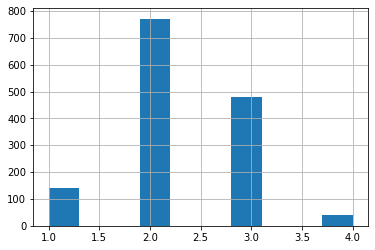

In [73]:
prepared_data[1]["OverallQual_cat"] = pd.cut(Train_set['OverallQual'],
                                              bins=[0., 4, 6., 8., np.inf],
                                              labels=[1, 2, 3, 4,])

prepared_data[1]["OverallQual_cat"].fillna(method='ffill', inplace=True)

prepared_data[1]["OverallQual_cat"].hist()

In [74]:
prepared_data[1]["OverallQual_cat"].value_counts()

2    771
3    479
1    141
4     41
Name: OverallQual_cat, dtype: int64

In [75]:
Strat_train_set, Strat_test_set = Split_Data_To_Train_Test_Set(Label="OverallQual_cat").fit_transform(prepared_data[1])

In [76]:
def Ratio_WoodFlSF_Cat_proportion(data):
    return data['OverallQual_cat'].value_counts() / len(data)

_, test_set = train_test_split(prepared_data[1], test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    'OverAll': Ratio_WoodFlSF_Cat_proportion(prepared_data[1]),
    'Stratified': Ratio_WoodFlSF_Cat_proportion(Strat_test_set),
    'Random': Ratio_WoodFlSF_Cat_proportion(test_set)
}).sort_index()

compare_props['Random %Error'] = 100 * compare_props['Random'] / compare_props['OverAll'] - 100
compare_props['Stratified %Error'] = 100 * compare_props['Stratified'] / compare_props['OverAll'] - 100

In [77]:
compare_props

,OverAll,Stratified,Random,Random %Error,Stratified %Error
1,0.098464,0.090592,0.080139,-18.610226,-7.994168
2,0.538408,0.540070,0.536585,-0.338490,0.308663
3,0.334497,0.344948,0.348432,4.165909,3.124250
4,0.028631,0.024390,0.034843,21.696269,-14.812612


In [79]:
prepared_data[1].drop(['SalePrice', 'OverallQual_cat'], axis=1, inplace=True)

In [86]:
def model_training(pip_dict=None, train_index=None, test_index=None, label=None):
    per_pipe_scores = {}

    for i, pipe in pip_dict.items():

        per_predictor = {}

        for name, model in zip(('lin_reg','tree_reg','rnd_forest_reg'),(lin_reg, tree_reg, rnd_forest_reg)):
            
            model.fit(pipe.loc[train_index].values, label.loc[train_index])
            
            predicet_y = model.predict(pipe.loc[test_index].values)
            
            per_predictor[name] = r2_score(label.loc[test_index], predicet_y)

        per_pipe_scores['Pipe_' +  str(i)] = per_predictor
        
    return per_pipe_scores

In [87]:
train_i = Strat_train_set.index
test_i = Strat_test_set .index

In [88]:
per_pipe_scores = model_training(pip_dict=prepared_data, train_index=train_i, test_index=test_i, label=Train_set_Labels)

In [89]:
pd.DataFrame(per_pipe_scores)

,Pipe_1,Pipe_2,Pipe_3
lin_reg,0.659874,0.661429,0.641313
tree_reg,0.676906,0.706834,0.675439
rnd_forest_reg,0.862622,0.865326,0.870259


# Train And Test ML Models

In [17]:
prepared_data =  fit_transform(Construct_Pipeline=Construct_Pipeline(thresh=0.2, scaler_con=False), train_set=Train_set)

In [19]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rnd_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [91]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rnd_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

def model_training(pip_dict=None, train_single_models=True, train_index=None, test_index=None, label=None):
    per_pipe_scores = {}

    for i, pipe in pip_dict.items():

        per_predictor = {}

        for name, model in zip(('lin_reg','tree_reg','rnd_forest_reg'),(lin_reg, tree_reg, rnd_forest_reg)):
            
            if (train_single_models):
                
                model.fit(pipe.loc[train_index].values, label.loc[train_index])
            
                predicet_y = model.predict(pipe.loc[test_index].values)

                per_predictor[name] = r2_score(label.loc[test_index], predicet_y)
                
            else:
                scores = cross_val_score(model, pipe.values, label, scoring='r2', cv=10)                
                per_predictor[name] = scores 

        per_pipe_scores['Pipe_' +  str(i)] = per_predictor
        
    return per_pipe_scores

In [100]:
def monitor_result(per_pipe_scores=None, train_single_models=False):
    
    if (train_single_models):
        return pd.DataFrame(per_pipe_scores)
    
    else:    
        df=pd.DataFrame()
        col1 = []
        col2 = []

        for name, val in per_pipe_scores.items():
            col1.append(name)
            for pred, scores in val.items():
                col2.append(pred)
                df = pd.concat([df, pd.DataFrame(scores)], axis=1)

        new_col1 = [item for item in col1 for i in range(len(set(col2)))]

        Scores_DF = pd.DataFrame(df.values, columns =[new_col1, col2])

        Statistics_DF = pd.concat([Scores_DF.mean(axis=0), Scores_DF.std(axis=0)], axis=1)
        Statistics_DF.columns=['Mean', 'Std']

        return (Scores_DF, Statistics_DF)


# Standardized and Trained

In [104]:
standard_fit_transform_dict = fit_transform(Construct_Pipeline(thresh=0.2, scaler_con=False), train_set=Train_set)
standard_scores = model_training(pip_dict=standard_fit_transform_dict, train_single_models=True,
                                train_index=train_i, test_index=test_i, label=Train_set_Labels)
standard_scores_df = monitor_result(per_pipe_scores=standard_scores, train_single_models=True)

In [105]:
standard_scores_df

,Pipe_1,Pipe_2,Pipe_3
lin_reg,0.640831,0.640831,0.641313
tree_reg,0.687232,0.687232,0.675439
rnd_forest_reg,0.868677,0.868677,0.870259


In [106]:
standard_fit_transform_dict = fit_transform(Construct_Pipeline(thresh=0.2, scaler_con=False), train_set=Train_set)
standard_scores = model_training(pip_dict=standard_fit_transform_dict, train_single_models=False,
                                train_index=train_i, test_index=test_i, label=Train_set_Labels)
standard_scores_df, standard_statistics_df = monitor_result(per_pipe_scores=standard_scores, train_single_models=False)

# Normalized and Trained 

In [109]:
normilize_fit_transform_dict = fit_transform(Construct_Pipeline(thresh=0.2, scaler_con=True), train_set=Train_set)
nomalized_scores = model_training(pip_dict=normilize_fit_transform_dict, train_single_models=False,
                                train_index=train_i, test_index=test_i, label=Train_set_Labels)
normilize_scores_df, normilize_statistics_df = monitor_result(per_pipe_scores=nomalized_scores, train_single_models=False)

In [110]:
pd.DataFrame(np.c_[standard_statistics_df.values, normilize_statistics_df.values],
             index=standard_statistics_df.index,
            columns=[['Standardized', 'Standardized', 'Normalized', 'Normalized'],
                    list(standard_statistics_df)*2])

Standardized           Normalized          
                              Mean       Std       Mean       Std
Pipe_1 lin_reg            0.801178  0.146908   0.804226  0.152579
       tree_reg           0.710974  0.077440   0.714020  0.071710
       rnd_forest_reg     0.869329  0.027856   0.869159  0.027924
Pipe_2 lin_reg            0.801178  0.146908   0.804226  0.152579
       tree_reg           0.710974  0.077440   0.714020  0.071710
       rnd_forest_reg     0.869329  0.027856   0.869159  0.027924
Pipe_3 lin_reg            0.799372  0.149346   0.805960  0.145644
       tree_reg           0.691216  0.069849   0.691579  0.070643
       rnd_forest_reg     0.869603  0.027161   0.869606  0.027138

# Monitor Results

In [100]:
(standard_statistics_df > normilize_statistics_df)

Mean    Std
Pipe_1 lin_reg         False  False
       tree_reg         True  False
       rnd_forest_reg  False   True
Pipe_2 lin_reg         False  False
       tree_reg         True  False
       rnd_forest_reg  False  False
Pipe_3 lin_reg          True   True
       tree_reg         True  False
       rnd_forest_reg   True  False
Pipe_4 lin_reg          True   True
       tree_reg         True  False
       rnd_forest_reg   True  False

In [ ]:
def display_scores(scores):    
    print("Scores : {0}".format(scores))
    print("Mean : {0}".format(scores.mean()))
    print("Standart Deviation {0}".format(scores.std()))